In [75]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

from tqdm import tqdm
from collections import Counter

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
stopwords = English.Defaults.stop_words
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cpu


In [76]:
# Reading CSV File into Pandas DataFrame

# Reading Train Dataset into DataFrame
df = pd.read_csv('Data/hw1_train-1.csv', index_col=0)
df.columns = ['text', 'labels']
df['labels'] = df['labels'].str.replace('none', '')
df['labels'] = df['labels'].fillna('')
print('Training Set Size:', df.size)

# Reading Test Dataset into DataFrame
test_df = pd.read_csv('Data/hw1_test-2.csv', index_col = 0)
test_df.columns = ['text']
print('Test Set Size:', test_df.size)

Training Set Size: 4624
Test Set Size: 981


In [77]:
# Splitting the Training dataset into the Training set and Validation set
train_data, val_data = train_test_split(df,
                                        random_state = 0, 
                                        test_size = 0.25, 
                                        shuffle = True)
print("Train Data: ")
print(train_data.head())
print("Val Data: ")
print(val_data.head())
print('Length -> Train Data: ', len(train_data))
print('Length -> Val Data: ', len(val_data))

Train Data: 
                                            text                        labels
ID                                                                            
909               can you show me movies spanish  movie.country movie.language
820                         in search for movies                              
1185  are there any g movies out there right now                  movie.rating
1971   show me more information about will smith                              
564                          who directed batman             movie.directed_by
Val Data: 
                                               text  \
ID                                                    
2154          show me the producer of the godfather   
563   can you tell me who is the director of batman   
789      get details of original finding nemo movie   
1325                             list french movies   
570    who directed the movie the thing called love   

                            labels  


In [78]:
# Create a set of Labels and a Dictionary to keep count of all labels
label_set = set()
label_count_dict = {}
for index, row in df.iterrows():
    temp = row['labels'].split()
    for item in temp:
        label_set.add(item)
        if item not in label_count_dict:
            label_count_dict[item] = 1
        else:
            label_count_dict[item] = label_count_dict[item] + 1 

label_list = np.reshape(np.array(list(label_set)), (-1, 1))

print('Label List: ', label_list)
print('Label Count Dictionary: ', label_count_dict)

Label List:  [['person.date_of_birth']
 ['movie.locations']
 ['movie.produced_by']
 ['movie.subjects']
 ['actor.gender']
 ['movie.country']
 ['movie.production_companies']
 ['movie.gross_revenue']
 ['movie.rating']
 ['movie.starring.actor']
 ['movie.directed_by']
 ['movie.language']
 ['gr.amount']
 ['movie.starring.character']
 ['movie.music']
 ['movie.estimated_budget']
 ['movie.initial_release_date']
 ['movie.genre']]
Label Count Dictionary:  {'movie.starring.actor': 355, 'movie.starring.character': 22, 'actor.gender': 9, 'person.date_of_birth': 6, 'movie.estimated_budget': 79, 'movie.directed_by': 346, 'movie.music': 3, 'movie.initial_release_date': 189, 'movie.locations': 3, 'movie.produced_by': 175, 'movie.production_companies': 93, 'movie.country': 223, 'movie.subjects': 94, 'movie.genre': 129, 'movie.language': 220, 'movie.rating': 211, 'movie.gross_revenue': 34, 'gr.amount': 5}


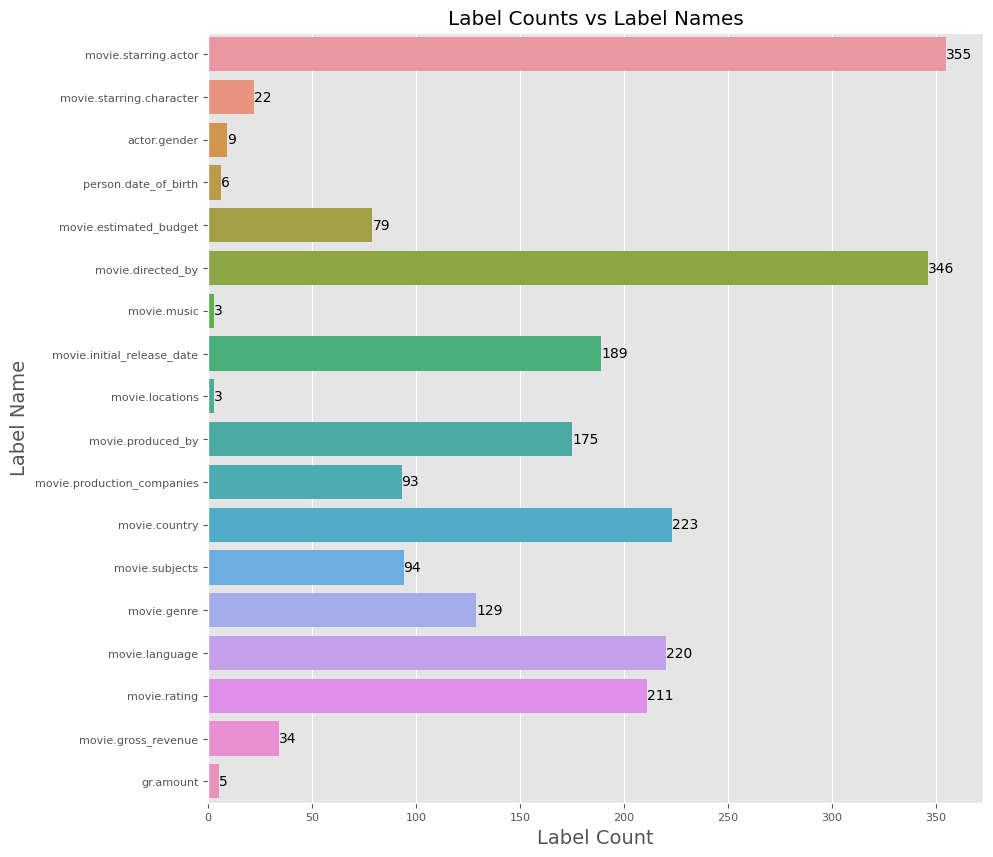

In [79]:
# Representation of Label Count in the Dataset
label_names = list(label_count_dict.keys())
label_counts = list(label_count_dict.values())

dataf = pd.DataFrame({"label_counts": label_counts, "label_names": label_names})
plt.figure(figsize = (10, 10))
splot = sns.barplot(x = "label_counts", y = "label_names" , data = dataf, orient ='h')
splot.bar_label(splot.containers[0], color='black')
plt.xlabel("Label Count", size = 14)
plt.ylabel("Label Name", size = 14)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title("Label Counts vs Label Names")

plt.show()

In [80]:
# Fit Multi-Label Binarizer to Label List
mlb.fit(label_list)
# print(mlb.classes_)

# Enumerate classes for Labels        
id_to_label = {}
for idx, label in enumerate(mlb.classes_):
    id_to_label[idx] = label
print('Id to Label Dictionary: ', id_to_label)  

Id to Label Dictionary:  {0: 'actor.gender', 1: 'gr.amount', 2: 'movie.country', 3: 'movie.directed_by', 4: 'movie.estimated_budget', 5: 'movie.genre', 6: 'movie.gross_revenue', 7: 'movie.initial_release_date', 8: 'movie.language', 9: 'movie.locations', 10: 'movie.music', 11: 'movie.produced_by', 12: 'movie.production_companies', 13: 'movie.rating', 14: 'movie.starring.actor', 15: 'movie.starring.character', 16: 'movie.subjects', 17: 'person.date_of_birth'}


In [81]:
# Fit Tf-Idf Vectorizer to training text
vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 2)

vectorizer.fit(train_data['text'])
print('Feature Names: ', vectorizer.get_feature_names_out())

def vectorize_to_tensor(text):
    text_list = []
    text_list.append(text)
    # Return tensor of encoded text using TF-IDF
    encoded = vectorizer.transform(text_list)
    encoded_tensor = torch.tensor(scipy.sparse.csr_matrix.todense(encoded)).float()
    return encoded_tensor

Feature Names:  ['1000' '1000 words' '13' ... 'zombie movies' 'zombies' 'zombies in']


In [141]:
# Relation Extraction Class for DataLoader
class RelationExtractionDataset(Dataset):
    
    def __init__(self, 
                 data: pd.DataFrame):
        self.data = data
        self.text = self.data['text']
        self.labels = self.data['labels']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, 
                    idx: int):
        text = self.text.iloc[idx]
        text = self.preprocess_text(self.text.iloc[idx])
        label = self.labels.iloc[idx].split()
        return self.encode_text(text), self.encode_label(label)

    def encode_text(self, 
                    text: str):
        return vectorize_to_tensor(text)
        
    def encode_label(self, 
                     label: str):
        # Convert label into NumPy matrix
        label_array = np.array(label)
        label_matrix = np.reshape(label_array, 
                                  (1, -1))
        # Return tensor of encoded label using Multi-Label Binarizer
        encoded = mlb.transform(label_matrix)
        encoded_label = torch.from_numpy(encoded)
        return encoded_label
         
    def tokenize(self, 
                 text: str):
        return [i.text for i in tokenizer(text)]

    def stopword_removal(self,
                         text: str):
        corpus = []
        for item in self.tokenize(text):
            if item not in stopwords:
                corpus.append(item)
        corpus = ' '.join(corpus)          
        return corpus

    def preprocess_text(self, 
                        text: str):
        # Convert text to lowercase
        text = text.lower()
        # Removing text contractions
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"i'd", "i would", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"don't", "donot", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"could't", "could not", text)
        text = re.sub(r"should'nt", "should not", text)
        text = re.sub(r"won't", "will not", text)
        # Removing all punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Removing links
        text = re.sub(r'http\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
        # Removing single characters
        text = re.sub(r's+[a-zA-Z]s+', '', text)
        # Removing stopwords
        text = self.stopword_removal(text)
        # Replacing multi-spaces by a single space
        text = re.sub(r'\s+', ' ', text)
        return text

In [142]:
# Relation Extraction Object for DataLoader
train_ds = RelationExtractionDataset(train_data)
val_ds = RelationExtractionDataset(val_data)

In [143]:
# PyTorch Data Loader
train_loader = DataLoader(train_ds, 
                          batch_size = 16, 
                          shuffle = True)
val_loader = DataLoader(val_ds, 
                        batch_size = 1, 
                        shuffle = True)

In [144]:
# Multi-Layer Perceptron with 1 hidden layer
class MLP(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim, 
        output_dim
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, 
                x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output  

# # Multi-Layer Perceptron with 2 hidden layers
# class MLP(nn.Module):
#     def __init__(
#         self, 
#         input_dim, 
#         hidden_dim_1,
#         hidden_dim_2,
#         output_dim
#     ):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim_1)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
#         self.fc3 = nn.Linear(hidden_dim_2, output_dim)
#         self.sigmoid = torch.nn.Sigmoid()
    
#     def forward(self, 
#                 x):
#         hidden1 = self.fc1(x)
#         relu1 = self.relu(hidden1)
#         hidden2 = self.fc2(relu1)
#         relu2 = self.relu(hidden2)
#         hidden3 = self.fc3(relu2)
#         output = self.sigmoid(hidden3)
#         return output  

In [145]:
torch.manual_seed(32)
input_features_dim = train_ds[0][0].shape[1]
output_dim = len(label_set)

print('Input Features Dimensions: ', input_features_dim)
print('Output Dimensions: ', output_dim)

# Instantiation of the MLP Model
model = MLP(input_features_dim, 
            50, 
            output_dim).to(device)

# model = MLP(input_features_dim, 
#             50, 
#             50, 
#             output_dim).to(device)
print(model)

Input Features Dimensions:  1576
Output Dimensions:  18
MLP(
  (fc1): Linear(in_features=1576, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)


In [146]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y in pbar:
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        y = y.squeeze()
        y = y.to(torch.float32)
        
        y_pred = y_pred.squeeze()
        y_pred = y_pred.to(torch.float32)
        
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss: ': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return sum(losses) / len(losses)

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn, 
             score_fn):
    model.eval()
    predictions = []
    labels = []
    losses = []
    for x, y in tqdm(loader):
        y_pred = model(x)
        y_pred = torch.round(y_pred)
        
        y = y.squeeze()
        y = y.to(torch.float32)
        
        y_pred = y_pred.squeeze()
        y_pred = y_pred.to(torch.float32)
        
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        
        y = y.detach().numpy()
        y_pred = y_pred.detach().numpy()
        
        labels.append(y)
        predictions.append(y_pred)
    
    score = score_fn(labels, predictions, average = 'samples', zero_division = 1)
    return labels, predictions, sum(losses) / len(losses), score

In [147]:
# Model Training on Train dataset and Evaluation on Validation dataset

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.04)
loss_fn = nn.BCELoss()
score_fn = f1_score

train_loss_list = []
val_loss_list = []
f1_score_list = []
n_epochs = 20
best_acc = 0
PATH = f'best-model.pt'
for epoch in range(n_epochs):
    # Model Training
    train_loss = train(train_loader, 
                     model, 
                     optimizer, 
                     loss_fn)
    print('Train Loss: ', train_loss)
    train_loss_list.append(train_loss)
    
    # Model Evaluation
    labels, predictions, val_loss, accuracy = evaluate(val_loader, 
                                                       model, 
                                                       loss_fn, 
                                                       score_fn)
    print('Val Accuracy: ', accuracy)
    print('Val Loss: ', val_loss)
    val_loss_list.append(val_loss)
    f1_score_list.append(accuracy)
    
    # Save model if Validation F1_Score is greather tha 75%
    if accuracy > best_acc and accuracy > 0.75:
        torch.save(model.state_dict(), PATH)
        cm = multilabel_confusion_matrix(labels, predictions)

100%|█████████████████████████| 109/109 [00:00<00:00, 154.79it/s, Loss: =0.0711]


Train Loss:  0.1503795675865007


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2671.64it/s]


Val Accuracy:  0.7061707035755478
Val Loss:  2.220299799962027


100%|█████████████████████████| 109/109 [00:00<00:00, 161.32it/s, Loss: =0.0386]


Train Loss:  0.03802953123055194


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2526.24it/s]


Val Accuracy:  0.7430795847750865
Val Loss:  2.1530179878419657


100%|████████████████████████| 109/109 [00:00<00:00, 159.33it/s, Loss: =0.00822]


Train Loss:  0.024116095206742988


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2493.42it/s]


Val Accuracy:  0.7653979238754325
Val Loss:  2.1530179878419657


100%|███████████████████████| 109/109 [00:00<00:00, 158.73it/s, Loss: =0.000195]


Train Loss:  0.019163521617616808


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2514.66it/s]


Val Accuracy:  0.7639561707035756
Val Loss:  2.018454363601843


100%|█████████████████████████| 109/109 [00:00<00:00, 171.60it/s, Loss: =0.0213]


Train Loss:  0.017848037730650378


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2789.91it/s]


Val Accuracy:  0.7734717416378316
Val Loss:  2.287581612082089


100%|█████████████████████████| 109/109 [00:00<00:00, 169.98it/s, Loss: =0.0437]


Train Loss:  0.016672412051558665


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2761.73it/s]


Val Accuracy:  0.7619377162629757
Val Loss:  2.047289425939012


100%|█████████████████████████| 109/109 [00:00<00:00, 171.32it/s, Loss: =0.0134]


Train Loss:  0.015371379618738017


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2773.10it/s]


Val Accuracy:  0.7685697808535179
Val Loss:  2.0761244882761813


100%|████████████████████████| 109/109 [00:00<00:00, 179.45it/s, Loss: =0.00529]


Train Loss:  0.01493158801982111


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2776.18it/s]


Val Accuracy:  0.7596309111880046
Val Loss:  2.1434063003962427


100%|█████████████████████████| 109/109 [00:00<00:00, 175.16it/s, Loss: =0.0119]


Train Loss:  0.01257474177277758


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2788.03it/s]


Val Accuracy:  0.7538638985005768
Val Loss:  2.1530179878419657


100%|█████████████████████████| 109/109 [00:00<00:00, 169.09it/s, Loss: =0.0217]


Train Loss:  0.01259338112808059


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2793.73it/s]


Val Accuracy:  0.757035755478662
Val Loss:  2.0665128008304583


100%|█████████████████████████| 109/109 [00:00<00:00, 180.96it/s, Loss: =0.0136]


Train Loss:  0.012338954674180409


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2804.42it/s]


Val Accuracy:  0.7653979238754325
Val Loss:  2.0857361757219044


100%|███████████████████████| 109/109 [00:00<00:00, 178.36it/s, Loss: =0.000346]


Train Loss:  0.012352408203304374


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2805.18it/s]


Val Accuracy:  0.7569204152249135
Val Loss:  2.201076425070581


100%|███████████████████████| 109/109 [00:00<00:00, 182.58it/s, Loss: =0.000145]


Train Loss:  0.010861510812617848


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2816.39it/s]


Val Accuracy:  0.7604959630911188
Val Loss:  2.172241362733412


100%|████████████████████████| 109/109 [00:00<00:00, 184.45it/s, Loss: =0.00241]


Train Loss:  0.011185049064406151


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2815.47it/s]


Val Accuracy:  0.7573241061130335
Val Loss:  2.181853050179135


100%|███████████████████████| 109/109 [00:00<00:00, 183.90it/s, Loss: =0.000817]


Train Loss:  0.011936509203157225


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2819.46it/s]


Val Accuracy:  0.7544405997693195
Val Loss:  2.22991148740775


100%|█████████████████████████| 109/109 [00:00<00:00, 176.16it/s, Loss: =0.0221]


Train Loss:  0.011274802130783178


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2757.74it/s]


Val Accuracy:  0.7513840830449827
Val Loss:  2.345251736756427


100%|█████████████████████████| 109/109 [00:00<00:00, 172.71it/s, Loss: =0.0261]


Train Loss:  0.011251423889749743


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2768.60it/s]


Val Accuracy:  0.7645328719723183
Val Loss:  2.162629675287689


100%|███████████████████████| 109/109 [00:00<00:00, 178.75it/s, Loss: =0.000194]


Train Loss:  0.011071538961564037


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2802.73it/s]


Val Accuracy:  0.7665513264129182
Val Loss:  2.028066051047566


100%|█████████████████████████| 109/109 [00:00<00:00, 180.92it/s, Loss: =0.0263]


Train Loss:  0.010291068529130233


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2776.25it/s]


Val Accuracy:  0.7512687427912341
Val Loss:  2.0761244882761813


100%|████████████████████████| 109/109 [00:00<00:00, 181.59it/s, Loss: =6.19e-5]


Train Loss:  0.010180667347588188


100%|███████████████████████████████████████| 578/578 [00:00<00:00, 2809.88it/s]

Val Accuracy:  0.7622260668973472
Val Loss:  2.172241362733412


Train Loss:  [0.14130460850279267, 0.024418654555770986, 0.011182879632842991, 0.006092355980291116, 0.00514897746645414, 0.004978567289539352, 0.003780448458818591, 0.003930226031641707, 0.003382639352412715, 0.0023677453571992473, 0.00253189024058867, 0.0022912428180419855, 0.00203394692938456, 0.0020270103885345757, 0.0018979679422095655, 0.0023215416596539975, 0.0018748129333714942, 0.0017557892404744854, 0.0015051530592512406, 0.001995009468941001]
Val Loss:  [1.9511725514817815, 1.7781621774587664, 1.7685504900130433, 1.6724336155558128, 1.6628219281100898, 1.7781621774587664, 1.710880365338705, 1.6435985532186435, 1.4994232415327977, 1.6532102406643667, 1.6147634908814743, 1.547481678761413, 1.6628219281100898, 1.5859284285443052, 1.6628219281100898, 1.6243751783271974, 1.691656990447259, 1.8166089272416586, 1.6435985532186435, 1.710880365338705]


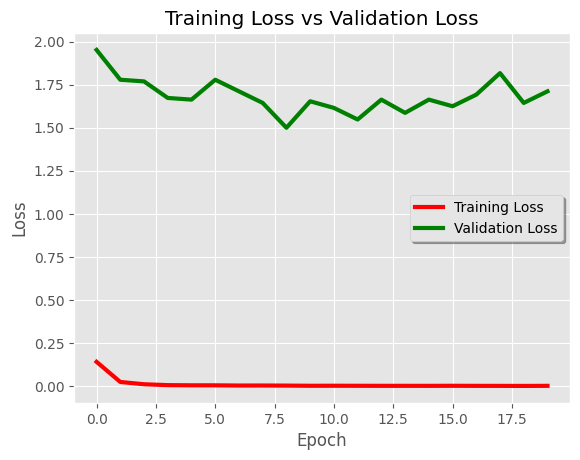

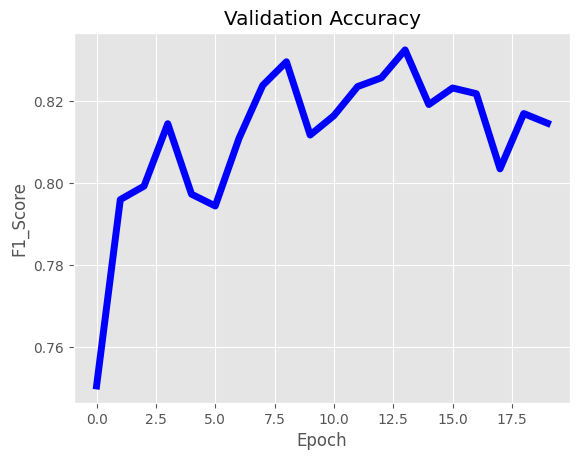

In [137]:
# Training vs Validation Loss Plot
epochs = np.arange(0, n_epochs)  
print('Train Loss: ', train_loss_list)
print('Val Loss: ', val_loss_list)

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label = "Training Loss", color="red", linewidth = '3')
plt.plot(epochs, val_loss_list, label = "Validation Loss", color="green", linewidth = '3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss', color = 'black')
plt.legend(shadow = True, labelcolor = 'black')
plt.show()  

# Validation Accuracy Plot
plt.plot(epochs, f1_score_list, color = 'blue', linewidth = '5')
plt.xlabel('Epoch')
plt.ylabel('F1_Score')
plt.title('Validation Accuracy', color = 'black')
plt.show()  


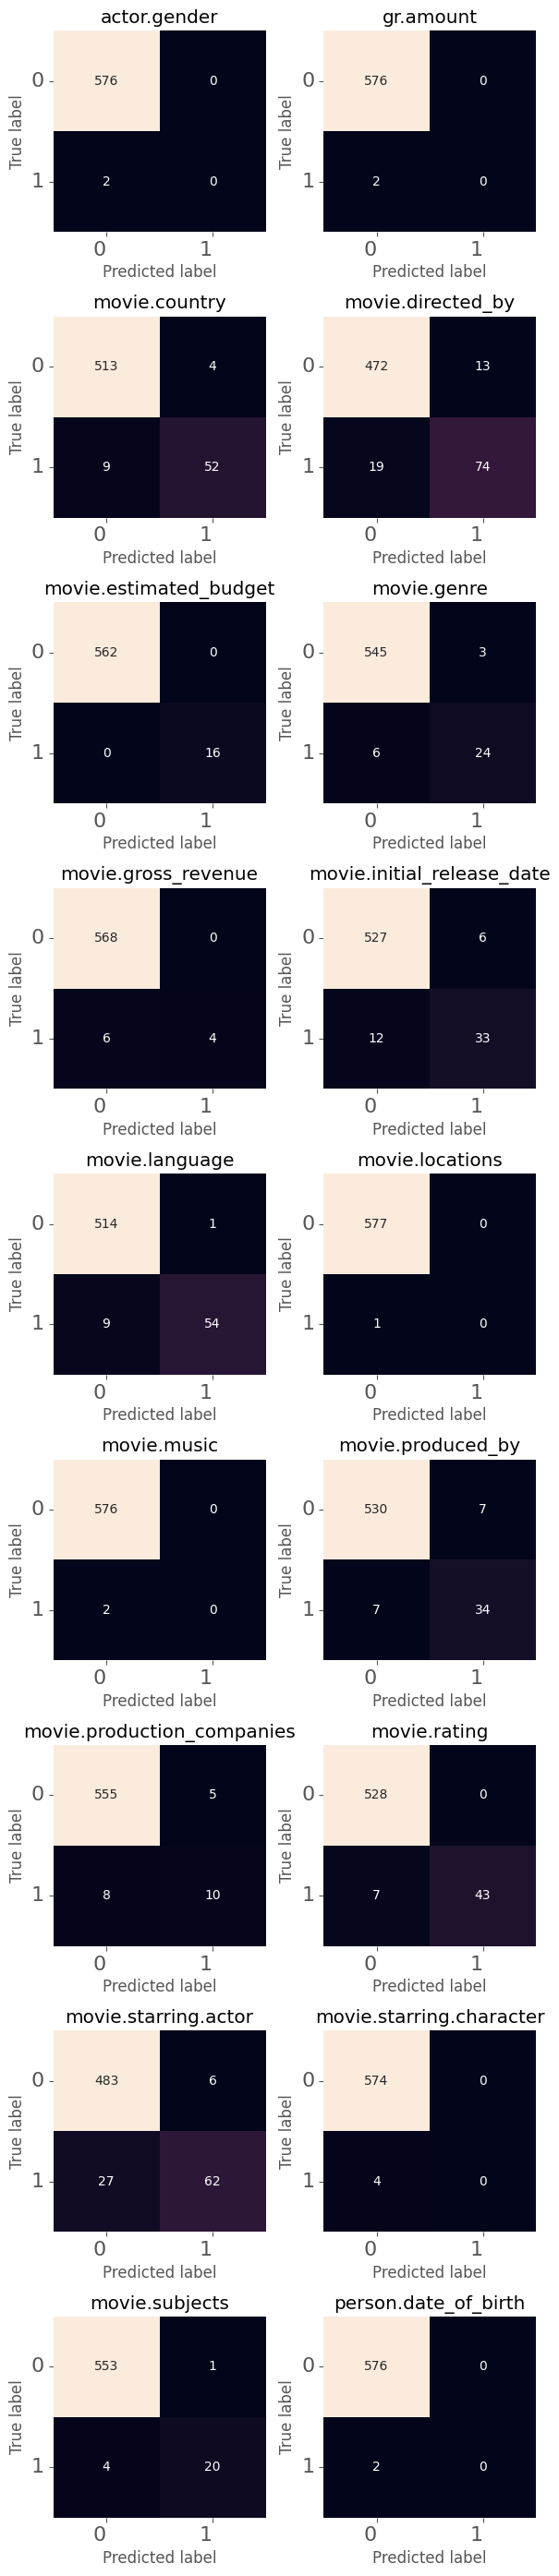

In [116]:
# Confusion Matrix for 18 Classes
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 16):
    df_cm = pd.DataFrame(confusion_matrix, 
                         index = class_names, 
                         columns = class_names)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

cm_labels = []    
for key, value in id_to_label.items():
    cm_labels.append(value)     
    
fig, ax = plt.subplots(9, 2, figsize = (6, 28))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()    

In [121]:
# Save and Load the Model
saved_model = MLP(input_features_dim, 
                  50,
                  output_dim).to(device)

# saved_model = MLP(input_features_dim, 
#                   50,
#                   50, 
#                   output_dim).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

MLP(
  (fc1): Linear(in_features=1576, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)

In [120]:
# Use Saved Model for Predictions
label_tensors = []
label_id = []
with torch.no_grad():
    for index, row in test_df.iterrows():
        text_tensor = vectorize_to_tensor(row.to_string())
        # Using Forward Pass of MLP for Predictions
        label_tensor = model.forward(text_tensor)
        label_tensor_round = torch.round(label_tensor)
        label_tensors.append(label_tensor_round)
        # Use Inverse_Transform function in MultiLabelBinarizer to get label names
        label_id.append(mlb.inverse_transform(label_tensor_round))

label_list = []
for i in range (0, len(label_id)):
    labels = list(label_id[i][0])
    label_list.append(labels)

# Creating Dictionary
list_of_dict = []

for i in range(0, len(label_list)):
    temp_dict = {}
    temp_dict["ID"] = i
    temp_dict["UTTERANCES"] = ' '.join(label_list[i])
    list_of_dict.append(temp_dict)

# Converting Dictionary to CSV and compressing it for submission to CodaLab
labels_df = pd.DataFrame.from_dict(list_of_dict)
labels_df.to_csv('submission.csv.zip', compression = 'zip', index = False)
print(labels_df)

      ID            UTTERANCES
0      0  movie.starring.actor
1      1                      
2      2  movie.starring.actor
3      3  movie.starring.actor
4      4  movie.starring.actor
..   ...                   ...
976  976                      
977  977  movie.starring.actor
978  978                      
979  979     movie.directed_by
980  980         movie.country

[981 rows x 2 columns]
